In [1]:
import xarray as xr 
import wclass
import constants as cnst
import matplotlib.pyplot as plt

In [2]:
dat = xr.open_dataarray(cnst.TESTDATA_TEMP).squeeze()

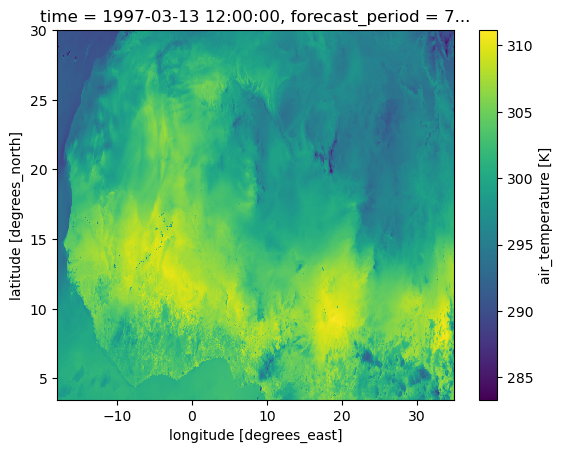

In [3]:
dat.plot()

In [4]:
# Let's zoom in to some max temperature location
dummy= dat.sel(longitude=slice(-10,25))
loc = dummy.where(dummy==dummy.max(), drop=True)

In [5]:
loc

<xarray.DataArray 't2' (latitude: 1, longitude: 1)>
array([[311.14087]], dtype=float32)
Coordinates:
    time                     object 1997-03-13 12:00:00
  * latitude                 (latitude) float32 9.292
  * longitude                (longitude) float32 18.94
    forecast_period          timedelta64[ns] 72 days 12:00:00
    forecast_reference_time  object 1997-01-01 00:00:00
    height                   float64 1.5
Attributes:
    standard_name:    air_temperature
    units:            K
    um_stash_source:  m01s03i236
    um_runid:         ac144
    um_streamid:      apc
    um_version:       10.3
    grid_mapping:     latitude_longitude

In [6]:
xx = 7
dat = dat.sel(latitude=slice(int(loc.latitude-xx),int(loc.latitude+xx+1)), longitude=slice(int(loc.longitude-xx),int(loc.longitude+xx+1)))

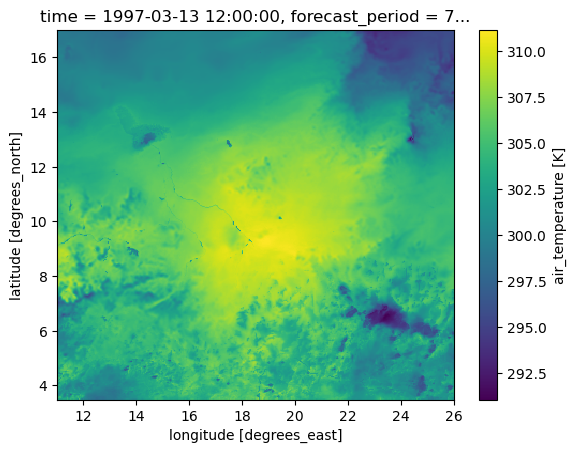

In [7]:
dat.plot()

In [8]:
### Create a wavelet decomposition object first. In this example, we initialise the CP4 temperature setup. The setups can be defined in land_wavelet.constants
wObj = wclass.landwav('T_CP4')

Initialised wavelet with scales:  [ 10.  20.  40.  80. 160. 320. 640.]


In [9]:
### The wObj object saves certain infos on the initialised wavelet as well as the dataset the wavelet it supposed to be used on. IT IS IMPORTANT THAT THE INITIALISED WAVELET KNOWS ABOUT THE DATASET RESOLUTION

print('Initialised dataset resolution (info from utility function):', wObj.res)
print('Initialised wavelet scale start (info from utility function):',wObj.start)
print('Initialised scale numbers (info from utility function):',wObj.nb)
print('Initialised scales:', wObj.scales)

Initialised dataset resolution (info from utility function): 4.4
Initialised wavelet scale start (info from utility function): 10
Initialised scale numbers (info from utility function): 6
Initialised scales: [ 10.  20.  40.  80. 160. 320. 640.]


In [10]:
### The next step prepares the temperature image for the wavelet routine. NaNs are removed by filling in zeros that can be masked again after wavelet application.
wObj.read_img(dat.values, dat.longitude.values, dat.latitude.values)

Mean res is 0.040500052  I found that grid is not regular. If in doubt, please check.


Text(0.5, 1.0, 'T2m anomaly without NaNs - note, there is ocean')

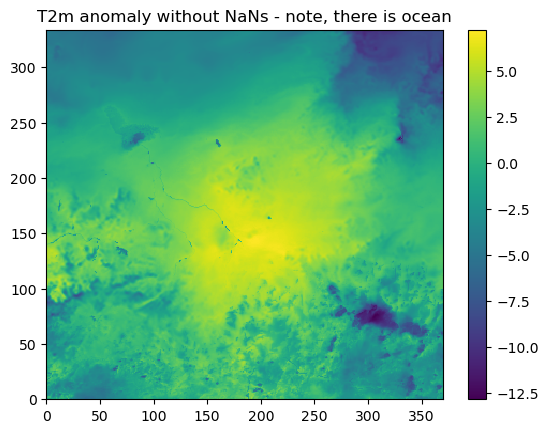

In [11]:
# The object saves the filtered image
plt.pcolormesh(wObj.image)  # the prepared (nans removed, anomaly) image
plt.colorbar()
plt.title('T2m anomaly without NaNs')

In [46]:
# We now apply the wavelet scale decomposition to the image as defined in the wObj object. This step saves wavelet coefficients and powers to the object.
# The resulting powers can be used for diverse analyses.

coeffs, power, scales, period = wObj.applyWavelet(normed='stddev', ge_thresh=None, le_thresh=0)

Wavelet coeffs (none or stddev) and power (none, stddev or scale) normed by: stddev Please note: Choose none if value reconstruction is intended.
getresh None lethresh 0


In [47]:
wObj.power.shape   # 0 dimension corresponds to number of decomposed scales

(7, 334, 370)

Text(0.5, 1.0, '160.0 km scale wavelet power')

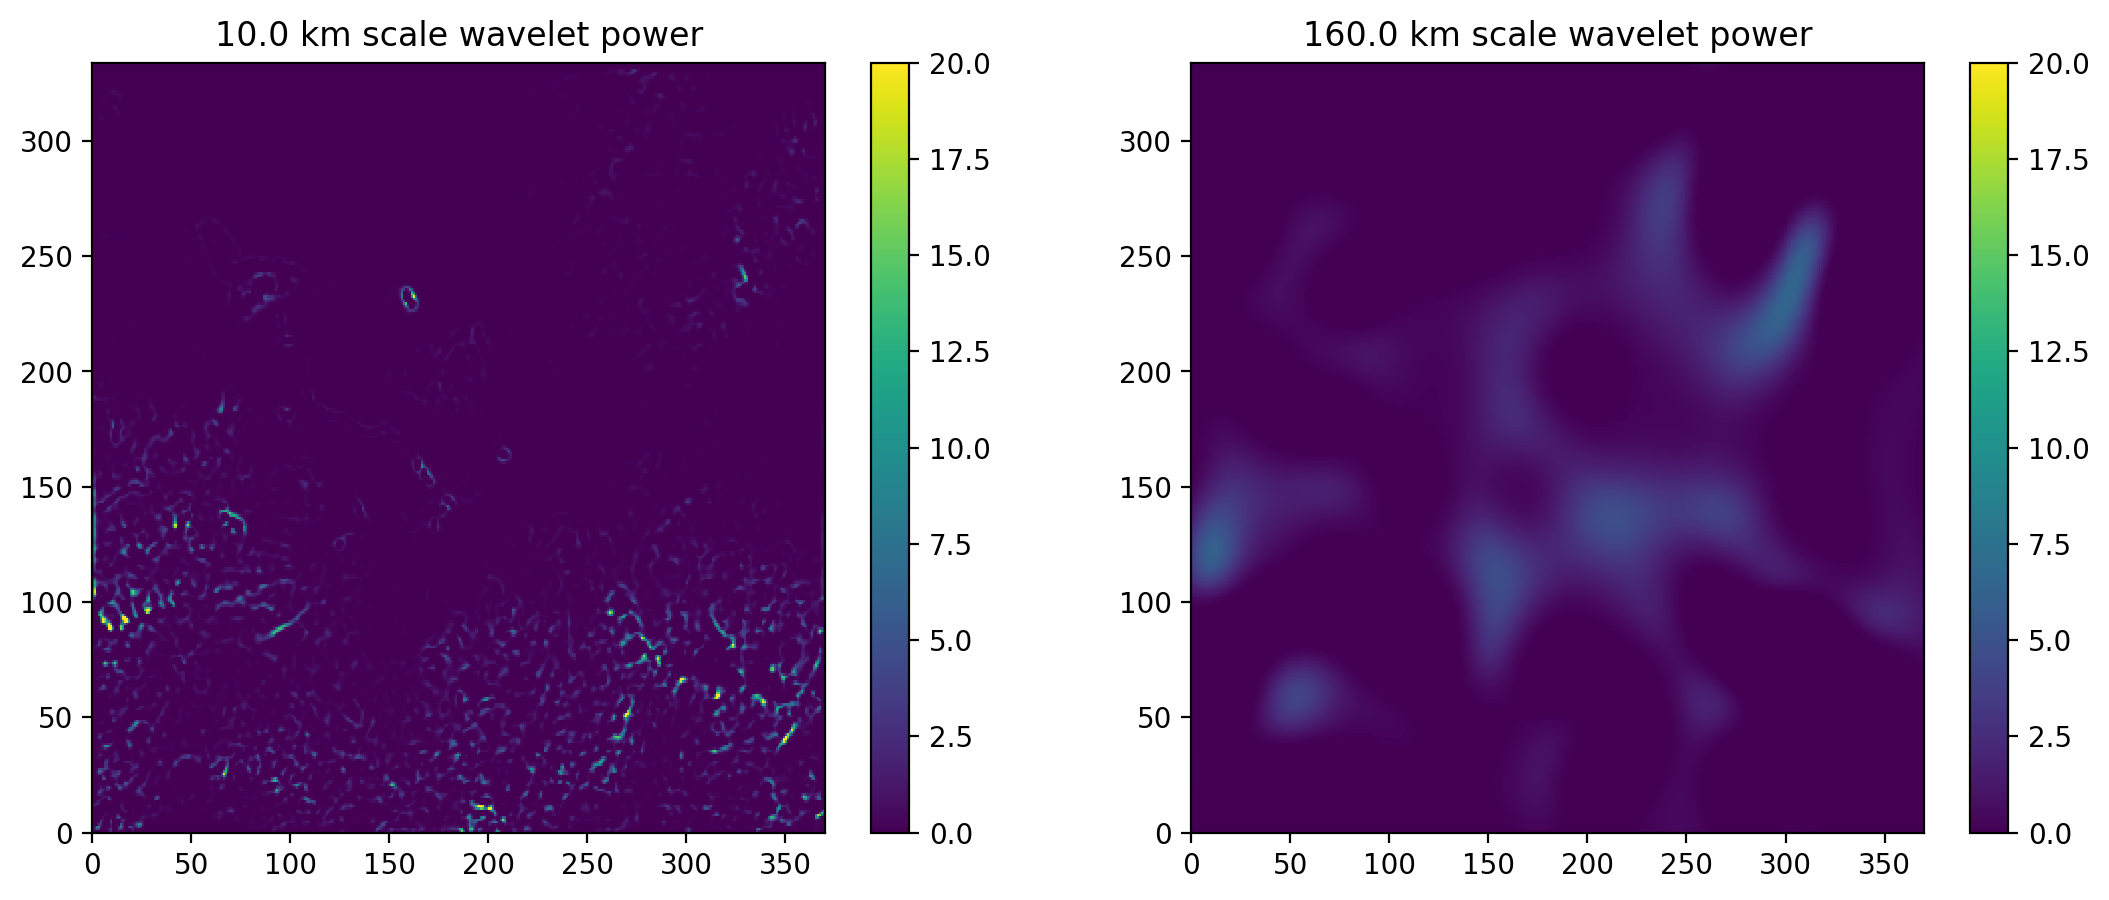

In [102]:
### This shows wavelet coefficient images of two chosen scales

f = plt.figure(figsize=(13,5), dpi=200)

ax = f.add_subplot(121)
scale_id = 0
plt.pcolormesh(wObj.power[scale_id,:,:], vmax=20)
plt.colorbar()
plt.title(str(wObj.scales[scale_id])+' km scale wavelet power')


ax = f.add_subplot(122)
scale_id = -3

plt.pcolormesh(wObj.power[scale_id,:,:], vmax=20)
plt.colorbar()
plt.title(str(wObj.scales[scale_id])+' km scale wavelet power')

Text(0.5, 1.0, 'Contours: 640.0 km power on T2m')

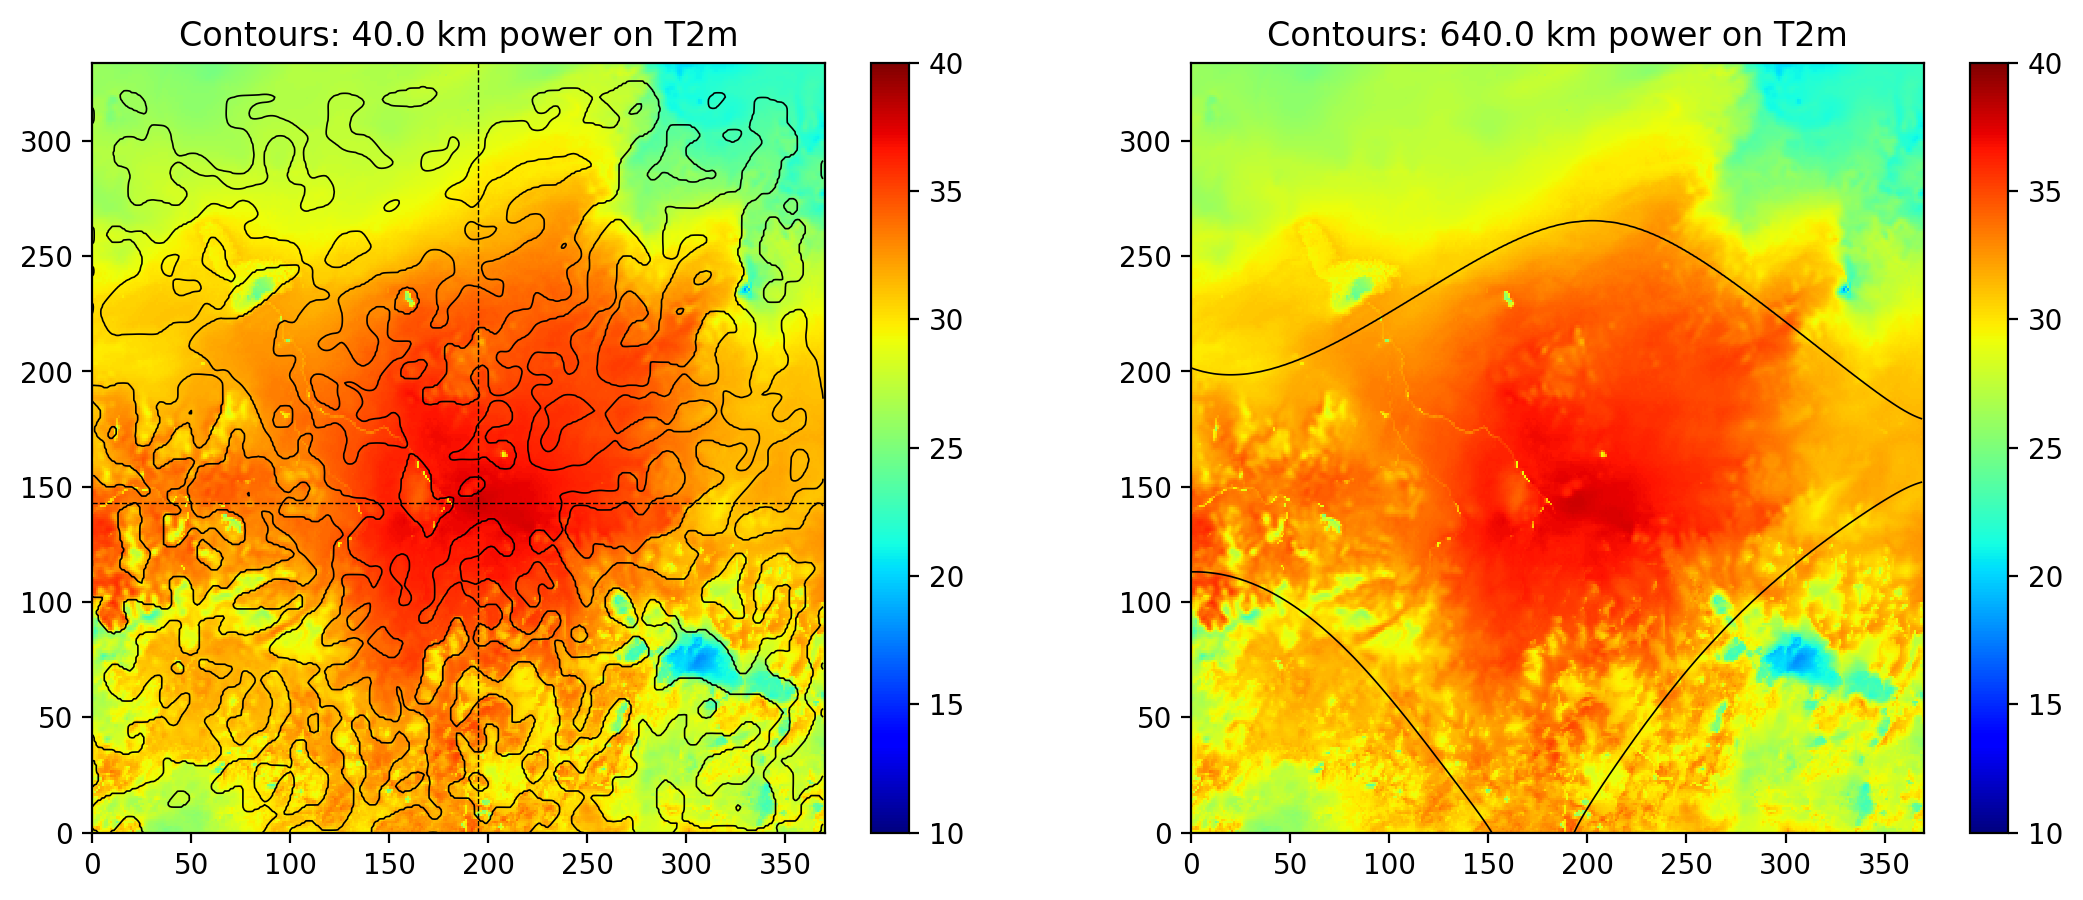

In [49]:
### Same powers as above but as contours plotted onto the SM image. 

f = plt.figure(figsize=(13,11), dpi=200)
pos=np.unravel_index(np.argmax(dat.values),dat.shape)

ax = f.add_subplot(221)

plt.pcolormesh(dat-273.15, vmax=40, vmin=10, cmap='jet')
plt.colorbar()
scale_id = 2
plt.contour(wObj.power[scale_id,:,:], levels=[-1,0.001,], colors=['k'], linewidths=0.6)
ax.axhline(pos[0], linestyle='dashed', color='k', linewidth=0.5)
ax.axvline(pos[1], linestyle='dashed', color='k', linewidth=0.5)
plt.title('Contours: '+str(np.floor(wObj.scales[scale_id]))+' km power on T2m')


ax = f.add_subplot(222)
scale_id = -1
plt.pcolormesh(dat-273.15, vmax=40, vmin=10, cmap='jet')
plt.colorbar()
plt.contour(wObj.power[scale_id,:,:], levels=[-1,0.001], colors=['k'], linewidths=0.6)
plt.title('Contours: '+str(np.floor(wObj.scales[scale_id]))+' km power on T2m')

Text(0, 0.5, 'temperature (K)')

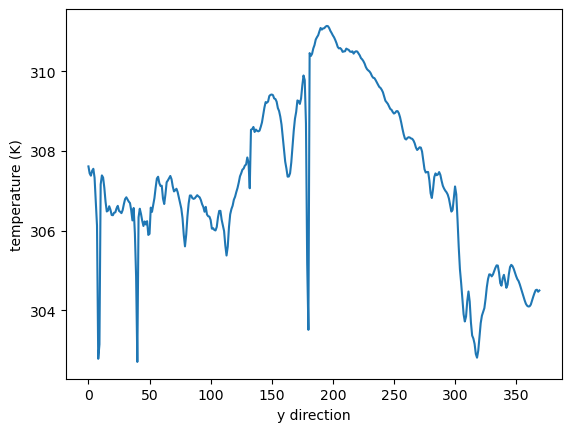

In [106]:
plt.plot(dat[pos[0], :]) # real temperature y direction
plt.xlabel('y direction')
plt.ylabel('temperature (K)')

Text(0, 0.5, 'temperature (K)')

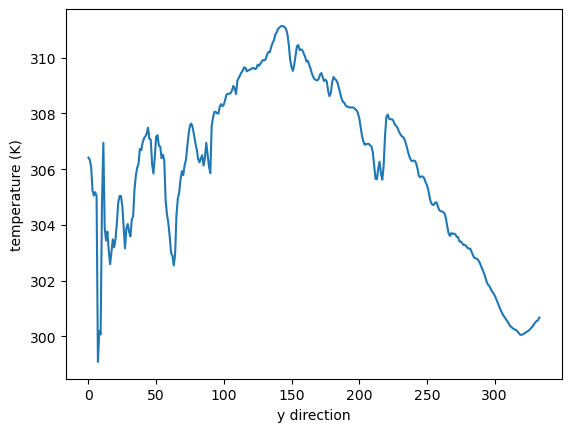

In [107]:
plt.plot(dat[:, pos[1]]) # real temperature x direction
plt.xlabel('y direction')
plt.ylabel('temperature (K)')

Text(0, 0.5, 'Power values at Tmax location')

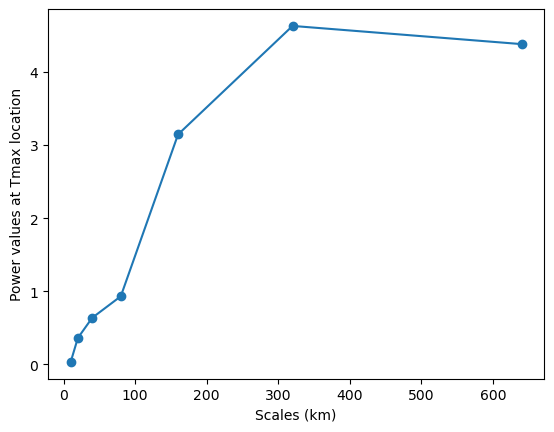

In [109]:
plt.plot(wObj.scales, wObj.power[:,pos[0], pos[1] ], marker='o')  # scale peak at Tmax centre point at 320 km 
plt.xlabel('Scales (km)')
plt.ylabel('Power values at Tmax location')

Text(0, 0.5, 'Scales (km)')

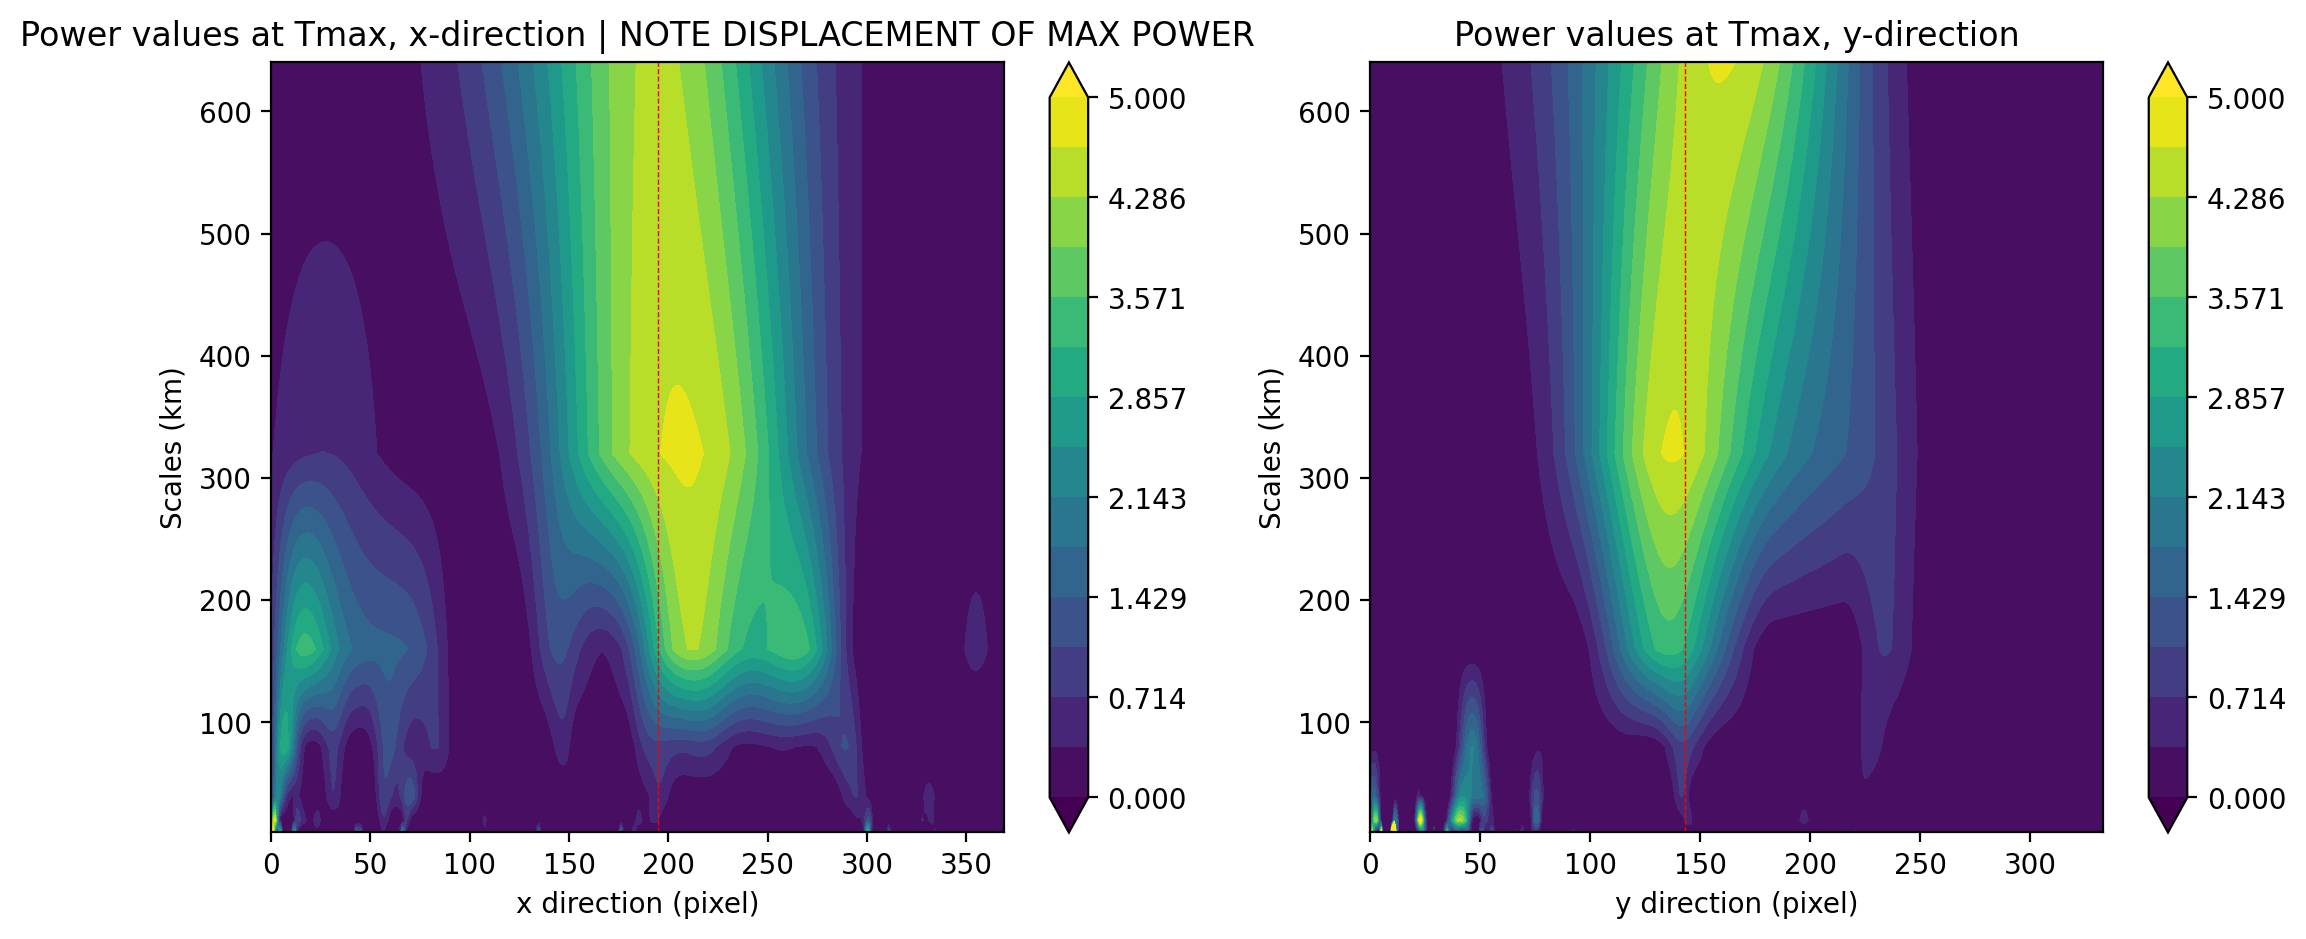

In [110]:
### Horizontal power cross-section through Tmax point showing all power values

f = plt.figure(figsize=(13,11), dpi=200)

ax = f.add_subplot(221)

plt.contourf(np.arange(wObj.power.shape[2]), wObj.scales, wObj.power[:,pos[0], : ], levels=np.linspace(0,5,15), extend='both')
ax.axvline(pos[1], color='r', linestyle='dashed', linewidth=0.5)
plt.title('Power values at Tmax, x-direction | NOTE DISPLACEMENT OF MAX POWER')
plt.colorbar()
plt.xlabel('x direction (pixel)')
plt.ylabel('Scales (km)')

ax = f.add_subplot(222)
plt.contourf(np.arange(wObj.power.shape[1]), wObj.scales, wObj.power[:, : , pos[1]], levels=np.linspace(0,5,15), extend='both')
ax.axvline(pos[0], color='r', linestyle='dashed', linewidth=0.5)
plt.title('Power values at Tmax, y-direction')
plt.colorbar()
plt.xlabel('y direction (pixel)')
plt.ylabel('Scales (km)')


In [89]:
# Alternative method, scan image for max power location irrespective of scale

wpos = np.unravel_index(np.argmax(wObj.power), wObj.power.shape) # max power position in scale-space dimensions

In [90]:
wpos

(0, 88, 9)

In [99]:
def draw_cut_circle(x, y, radius, array):

    ycirc, xcirc = draw_circle(x, y, radius)
    noky = np.where(ycirc >= array.shape[0])  # if the circle is off the edge
    if noky[0].size > 0:
        ycirc = np.delete(ycirc, noky)
        xcirc = np.delete(xcirc, noky)

    nokx = np.where(xcirc >= array.shape[1])
    if nokx[0].size > 0:
        ycirc = np.delete(ycirc, nokx)
        xcirc = np.delete(xcirc, nokx)

    return (ycirc.astype(int), xcirc.astype(int))

def draw_circle(x, y, radius):

    xloc1 = np.arange(x - radius, x + radius + 1)
    yloc1 = np.arange(y - radius, y + radius + 1)
    xloc, yloc = np.meshgrid(xloc1, yloc1)
    distloc = ( ((xloc - x) * (xloc - x)) + ((yloc - y) * (yloc - y)) )**.5

    indloc = (distloc <= radius).nonzero()
    ycirc = indloc[0] - radius + y
    xcirc = indloc[1] - radius + x

    return (ycirc.astype(int), xcirc.astype(int))


Text(0.5, 1.0, 'Black circle left bottom quadrant = highest power (10km) across domain')

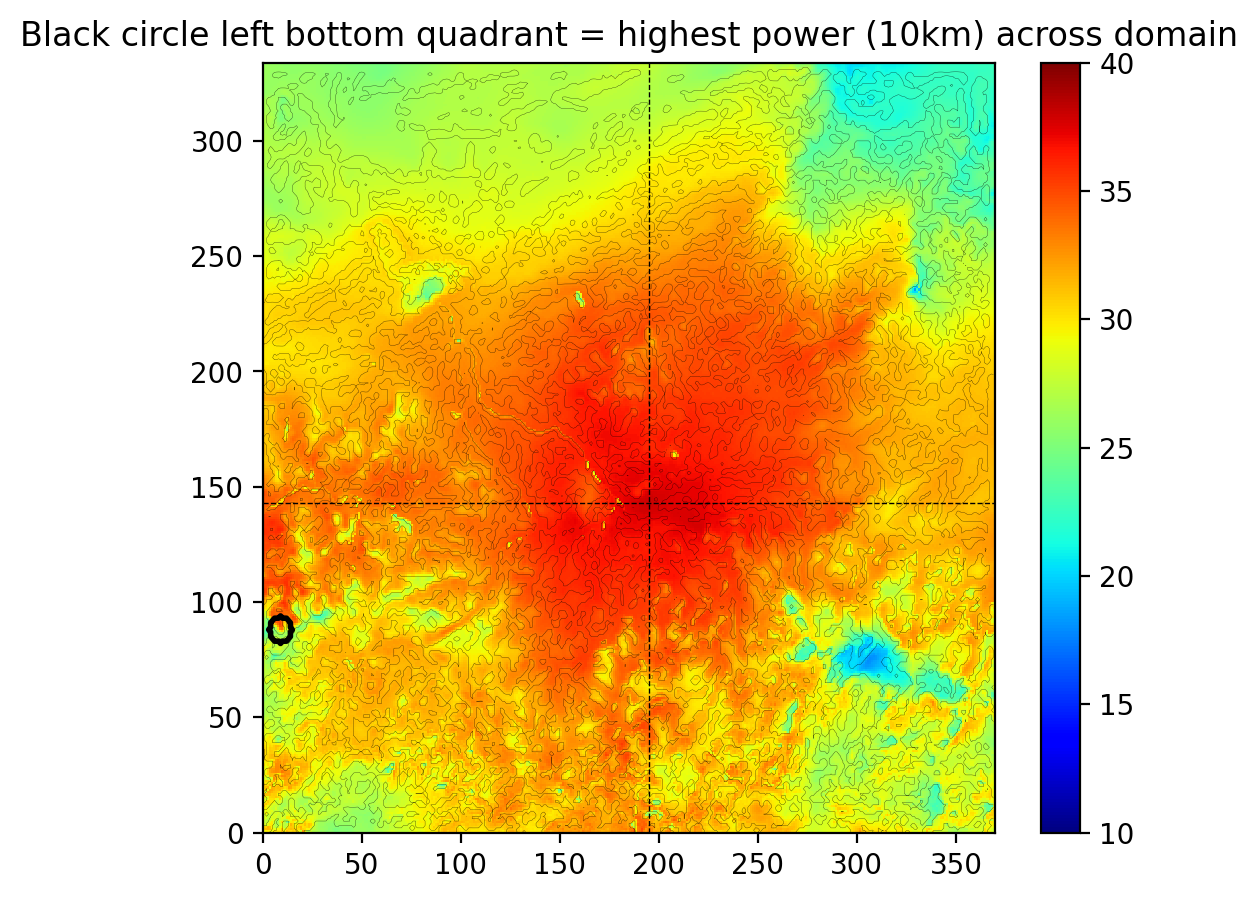

In [88]:
### Same powers as above but as contours plotted onto the SM image. 

circle = np.zeros_like(dat.values)
ycirc, xcirc = draw_cut_circle(wpos[2], wpos[1], int(wObj.scales[wpos[0]])/2, circle)
circle[ycirc, xcirc] =100


f = plt.figure(figsize=(13,11), dpi=200)
pos=np.unravel_index(np.argmax(dat.values),dat.shape)

ax = f.add_subplot(221)

plt.pcolormesh(dat-273.15, vmax=40, vmin=10, cmap='jet')
plt.colorbar()
plt.contour(wObj.power[wpos[0],:,:], levels=[-1,0.001,], colors=['k'], linewidths=0.1)
plt.contour(circle, levels=[-1,1,101,], colors=['k'], linewidths=2)
ax.axhline(pos[0], linestyle='dashed', color='k', linewidth=0.5)
ax.axvline(pos[1], linestyle='dashed', color='k', linewidth=0.5)

plt.title('Black circle left bottom quadrant = highest power (10km) across domain')

Text(0, 0.5, 'Scales (km)')

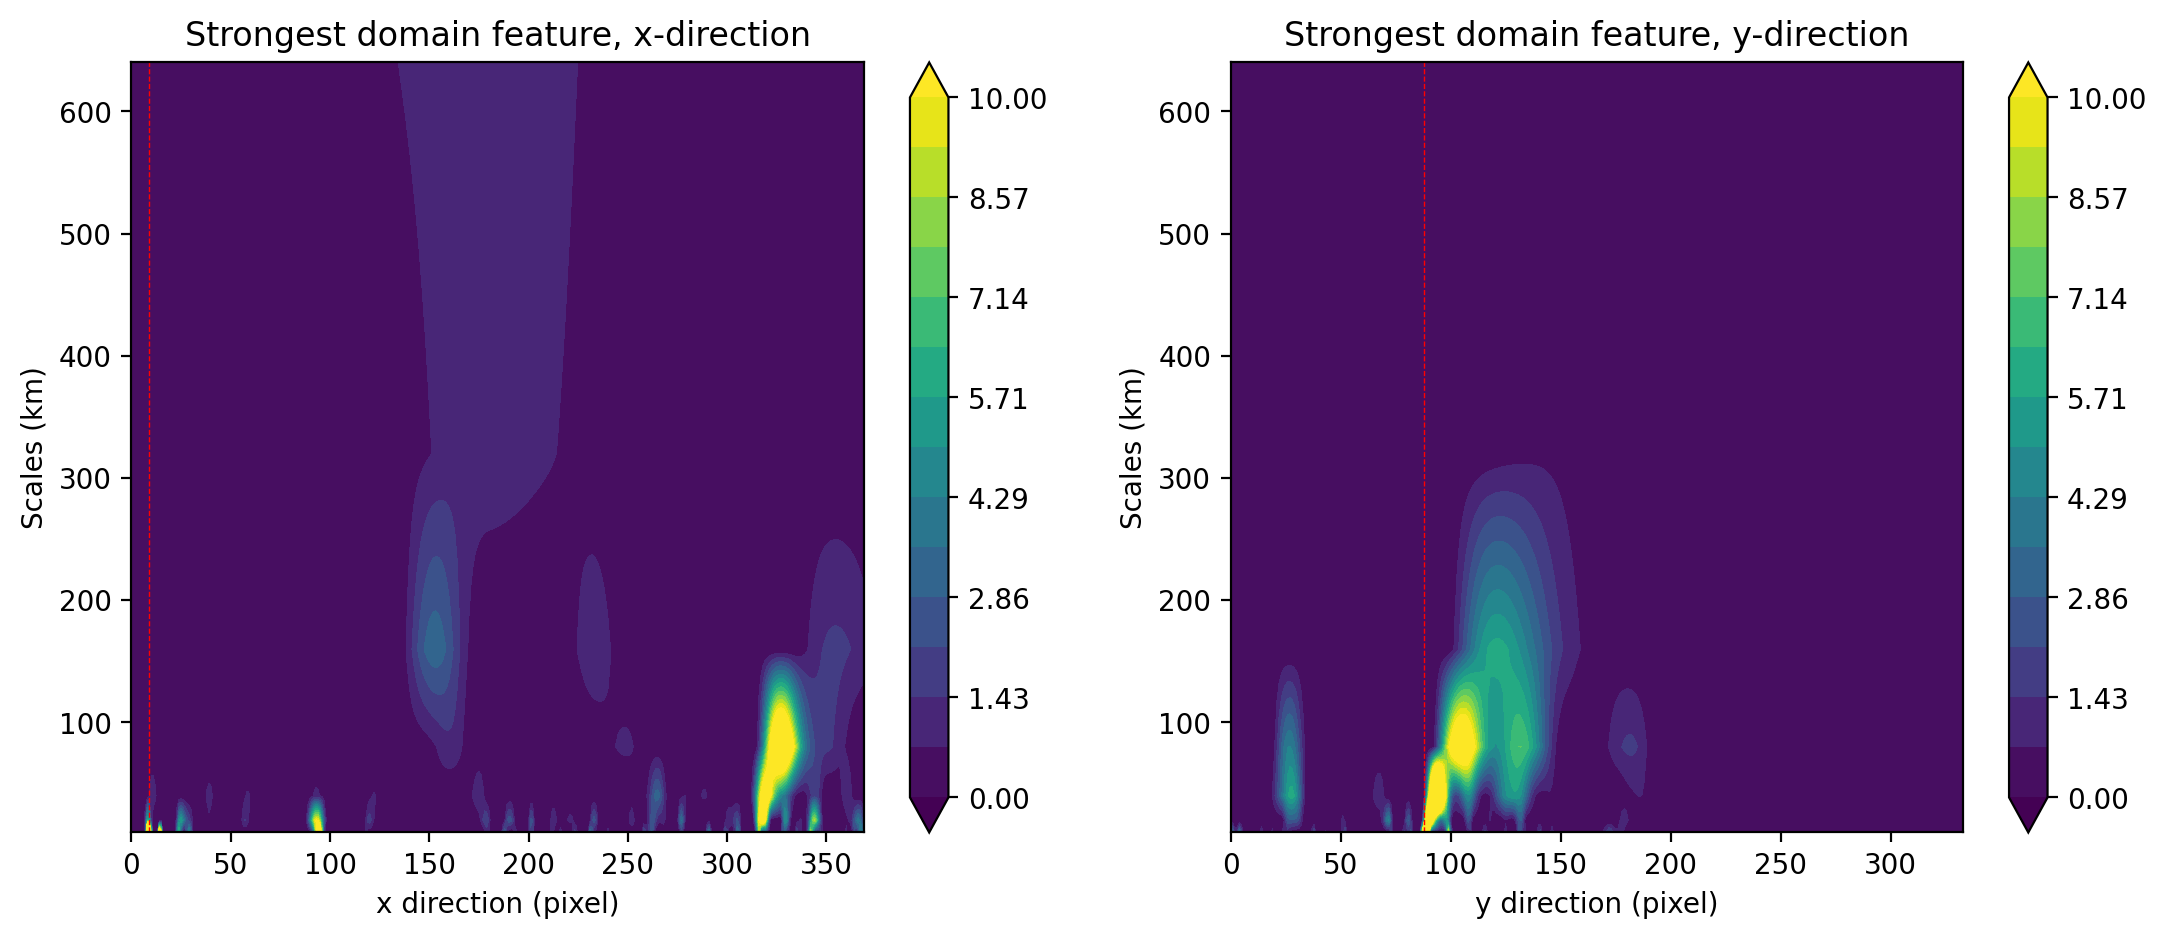

In [111]:
### Horizontal power cross-section through Tmax point showing all power values

f = plt.figure(figsize=(13,11), dpi=200)

ax = f.add_subplot(221)

plt.contourf(np.arange(wObj.power.shape[2]), wObj.scales, wObj.power[:,wpos[1], : ], levels=np.linspace(0,10,15), extend='both')
plt.title('Strongest domain feature, x-direction')
ax.axvline(wpos[2], color='r', linestyle='dashed', linewidth=0.5)
plt.colorbar()
plt.xlabel('x direction (pixel)')
plt.ylabel('Scales (km)')


ax = f.add_subplot(222)
plt.contourf(np.arange(wObj.power.shape[1]), wObj.scales, wObj.power[:, : , wpos[2]], levels=np.linspace(0,10,15), extend='both')
plt.title('Strongest domain feature, y-direction')
ax.axvline(wpos[1], color='r', linestyle='dashed', linewidth=0.5)
plt.colorbar()
plt.xlabel('y direction (pixel)')
plt.ylabel('Scales (km)')



In [94]:
wpos[2]

9